# Calculate and save HCW and tracer mass on shelf 

It has the same content as the script but I couldn't run ir remotely because of the netcdf library load.

In [19]:
# Calculate and save HCW and tracer mass on shelf
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [2]:
# -------------------------------------------------------------------------------------------------------------------------
def Tracer_AlongShelf(Tr,TrAdv,MaskC,rA,hFacC,drF,yin,zfin,xi,yi,nzlim):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, size 19x90x360x360
    TrAdv : Array with concentration values for low diffusivity tracer. Until this function is more general, size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    TrMass =  Array with the mass of tracer over the shelf in HCW at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) over the shelf at 
                    every time output. 
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = mtt.maskExpand(MaskC,TrAdv)

    TrAdv_profile=np.ma.array(TrAdv[0,:,yi,xi],mask=maskExp[0,:,yi,xi])   
    
    trlimAdv = TrAdv_profile[nzlim]
    
    print('Advective tracer limit concentration is: ',trlimAdv)
    
    TrMask=np.ma.array(TrAdv,mask=maskExp)  
    Tr1Mask=np.ma.array(Tr,mask=maskExp)   
    

    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlimAdv) 
    HighConc_Mask = HighConc_Masked.mask

    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)

    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
   
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    TrConc_HCW = np.ma.masked_array(Tr[:,:zfin,yin:,:],mask = HighConc_Mask)

    MassTrHighConc =np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol*TrConc_HCW,axis = 1),axis=1),axis=1)

    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*Tr1Mask[:,:zfin,yin:,:],axis = 1),axis=1),axis=1)
    
    return (MassTrHighConc, Total_Tracer)

In [3]:
# Load grid files
CanyonGrid='/data/kramosmu/results/TracerExperiments/UPWELLING_8TR/03_Bar/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/UPWELLING_8TR/04_Bar_No_Cny/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/UPWELLING_8TR/03_Bar/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']
drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

Shelf break index is 36, and shelf break is at -195.0 m
Initial concentration of AdvTr at shelf break is 32.3 uM


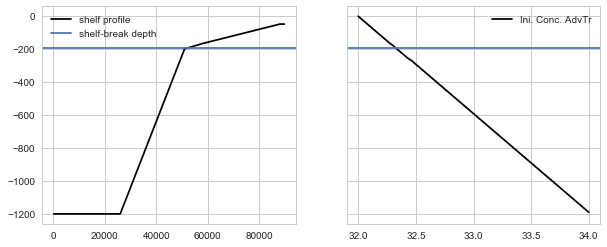

In [24]:
# Find shelf-break index

sb_ind = 36

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
ax[0].plot(yc[:,300], -bathy[:,300], 'k-', label='shelf profile')
ax[0].axhline(rc[sb_ind], label='shelf-break depth')
ax[0].legend(loc=0)
print('Shelf break index is %d, and shelf break is at %1.1f m' %(sb_ind, rc[sb_ind]))

filename=('/data/kramosmu/results/TracerExperiments/UPWELLING_8TR/03_Bar/ptracersGlob.nc')
TrAdv = rout.getField(filename,'Tr01') # tracer used to map upwelled water (linear)
    
ax[1].plot(TrAdv[0,:,50,180], rc, 'k-',label='Ini. Conc. AdvTr')
ax[1].axhline(rc[sb_ind])
ax[1].legend(loc=0)
print('Initial concentration of AdvTr at shelf break is %1.1f uM' %(TrAdv[0,sb_ind,50,180]))


In [11]:
expNames = ['UPWELLING_8TR']
trNames = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

In [12]:
# Calculate HCW and TR Mass
for exp in expNames:
    
    # initialize data arrays
    TrMassHCW = np.empty((8,19)) # 7 tracers and 21 time indices. Some have less than 21.
    TotTrMass = np.empty((8,19)) 
    HCW = np.empty((8,19)) 
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/03_Bar/ptracersGlob.nc' %exp)
    
    TrAdv = rout.getField(filename,'Tr01') # tracer used to map upwelled water (linear)
    
    for tr,ii in zip(trNames,range(8)):
       
        Tr = rout.getField(filename,tr) 
        
        TrMassHCWTemp, TotTrMassTemp = Tracer_AlongShelf(Tr,TrAdv, MaskCNoC, rA, hFacCNoC, 
                                                         drF[:], 227, sb_ind+1,  180, 50,sb_ind)
        TrMassHCW[ii,:] = TrMassHCWTemp[0:19]
        TotTrMass[ii,:] = TotTrMassTemp[0:19]
        
        HCWTemp = mtt.calc_HCW(TrAdv, MaskCNoC, rA, hFacCNoC, drF[:],
                               nzlim=sb_ind, yin=227, xin=0, 
                               xfin=359, zfin=sb_ind+1, xi=180, yi=50)
        
        HCW[ii,:] = HCWTemp[0:19]
       
                
    raw_data = {'time' : time[0:19],'HCW01': HCW[0,0:19],'HCW02': HCW[1,0:19],'HCW03': HCW[2,0:19],'HCW04': HCW[3,0:19],
                'HCW05': HCW[4,0:19],'HCW06': HCW[5,0:19],'HCW07': HCW[6,0:19],'HCW08': HCW[7,0:19],
                'TrMassHCW01':TrMassHCW[0,0:19],'TrMassHCW02':TrMassHCW[1,0:19],'TrMassHCW03':TrMassHCW[2,0:19],
                'TrMassHCW04':TrMassHCW[3,0:19],'TrMassHCW05':TrMassHCW[4,0:19],'TrMassHCW06':TrMassHCW[5,0:19],
                'TrMassHCW07':TrMassHCW[6,0:19],'TrMassHCW08':TrMassHCW[7,0:19],
                'TotTrMass01':TotTrMass[0,0:19],'TotTrMass02':TotTrMass[1,0:19],'TotTrMass03':TotTrMass[2,0:19],
                'TotTrMass04':TotTrMass[3,0:19],'TotTrMass05':TotTrMass[4,0:19],'TotTrMass06':TotTrMass[5,0:19],
                'TotTrMass07':TotTrMass[6,0:19],'TotTrMass08':TotTrMass[7,0:19]}
    
    
    df = pd.DataFrame(raw_data, columns = ['time' ,'HCW01','HCW02','HCW03','HCW04','HCW05','HCW06','HCW07','HCW08',
                                           'TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04','TrMassHCW05',
                                           'TrMassHCW06','TrMassHCW07','TrMassHCW08',
                                           'TotTrMass01','TotTrMass02','TotTrMass03',
                                           'TotTrMass04','TotTrMass05','TotTrMass06','TotTrMass07','TotTrMass08'])
    filename1 = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s_03_Bar.csv' %(exp,exp))
    df.to_csv(filename1)
    print(filename1)

Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
Advective tracer limit concentration is:  32.3264
tracer limit concentration is:  32.3264
/data/kramosmu/results/TracerExperiments/UPWELLING_8TR/HCW_TrMass_UPWELLING_8TR_03_Bar.csv


In [ ]:
# Calculate HCW and TR Mass
for exp in expNames:
    
    # initialize data arrays
    TrMassHCW = np.empty((8,19)) # 7 tracers and 21 time indices. Some have less than 21.
    TotTrMass = np.empty((8,19)) 
    HCW = np.empty((8,19)) 
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/04_Bar_No_Cny/ptracersGlob.nc' %exp)
    
    TrAdv = rout.getField(filename,'Tr01') # tracer used to map upwelled water (linear)
   
    for tr,ii in zip(trNames,range(8)):
    
             
        TrMassHCWTemp, TotTrMassTemp = Tracer_AlongShelf(Tr,TrAdv, MaskCNoC, rA, hFacCNoC, drF[:],
                                                         227, sb_ind+1,  180, 50,sb_ind)
        TrMassHCW[ii,:] = TrMassHCWTemp[0:19]
        TotTrMass[ii,:] = TotTrMassTemp[0:19]

        HCWTemp = mtt.calc_HCW(TrAdv, MaskCNoC, rA, hFacCNoC, drF[:],
                                nzlim=sb_ind, yin=227, xin=0, 
                                xfin=359, zfin=sb_ind+1, xi=180, yi=50)

        HCW[ii,:] = HCWTemp[0:19]
        
    raw_data = {'time' : time[0:19],'HCW01': HCW[0,0:19],'HCW02': HCW[1,0:19],'HCW03': HCW[2,0:19],'HCW04': HCW[3,0:19],
                'HCW05': HCW[4,0:19],'HCW06': HCW[5,0:19],'HCW07': HCW[6,0:19],'HCW08': HCW[7,0:19],
                'TrMassHCW01':TrMassHCW[0,0:19],'TrMassHCW02':TrMassHCW[1,0:19],'TrMassHCW03':TrMassHCW[2,0:19],
                'TrMassHCW04':TrMassHCW[3,0:19],'TrMassHCW05':TrMassHCW[4,0:19],'TrMassHCW06':TrMassHCW[5,0:19],
                'TrMassHCW07':TrMassHCW[6,0:19],'TrMassHCW08':TrMassHCW[7,0:19],
                'TotTrMass01':TotTrMass[0,0:19],'TotTrMass02':TotTrMass[1,0:19],'TotTrMass03':TotTrMass[2,0:19],
                'TotTrMass04':TotTrMass[3,0:19],'TotTrMass05':TotTrMass[4,0:19],'TotTrMass06':TotTrMass[5,0:19],
                'TotTrMass07':TotTrMass[6,0:19],'TotTrMass08':TotTrMass[7,0:19]}
    
    
    df = pd.DataFrame(raw_data, columns = ['time' ,'HCW01','HCW02','HCW03','HCW04','HCW05','HCW06','HCW07','HCW08',
                                           'TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04','TrMassHCW05',
                                           'TrMassHCW06','TrMassHCW07','TrMassHCW08',
                                           'TotTrMass01','TotTrMass02','TotTrMass03',
                                           'TotTrMass04','TotTrMass05','TotTrMass06','TotTrMass07','TotTrMass08'])
    filename1 = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s_04_Bar_No_Cny.csv' %(exp,exp))
    df.to_csv(filename1)
    print(filename1)